In [3]:
import torch

def Lines(text = "", count = 100):
    print("─"*100)
    if text != "":
        print(f"{text}")
        print("─"*count)

#────────────────────────────────────────
# [1] CPU/GPU할당 
#───────────────────────────────────────
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
#────────────────────────────────────────
# [2] 데이터셋 다운로드 및 기본정보
# - torch datasets에서
# - 10개의 사물 분류 32*32*3 칼라 이미지 6만장# 새 섹션
#───────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Cifar10 Transform 정의
# ----------------------------------------------------
transform = v2.Compose([
    v2.ToImage(),                # PIL / numpy → Image tensor
    v2.ToDtype(torch.float32, scale=True),  # 0~1 범위 실수화
])

# ----------------------------------------------------
#  Cifar10 데이터셋 로드
# ----------------------------------------------------
train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][0].min(), train_dataset[0][0].max())
print(train_dataset[0][1])
classes =train_dataset.classes
Lines("Class")
print(classes)
Lines()

50000
torch.Size([3, 32, 32])
tensor(0.) tensor(1.)
6
────────────────────────────────────────────────────────────────────────────────────────────────────
Class
────────────────────────────────────────────────────────────────────────────────────────────────────
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
────────────────────────────────────────────────────────────────────────────────────────────────────



샘플 이미지 5개 표시:


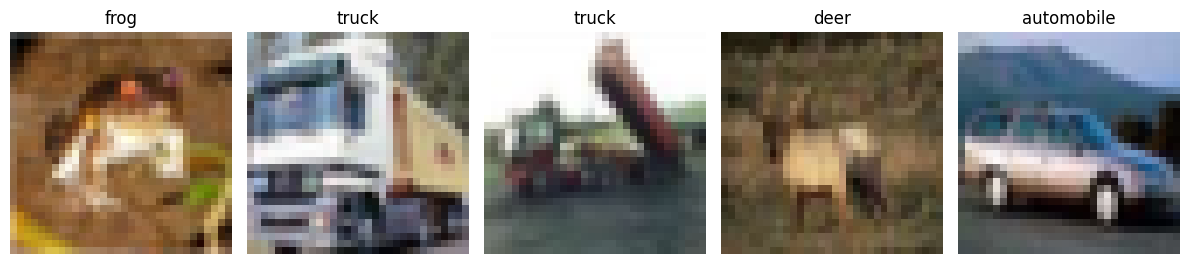

In [ ]:
#────────────────────────────────────────
# [2.1] 테스트 시각화.
#────────────────────────────────────────
print("\n샘플 이미지 5개 표시:")
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, label = train_dataset[i]
    # Tensor를 이미지로 변환: (C, H, W) -> (H, W, C)
    img = img.permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].set_title(f'{classes[label]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#────────────────────────────────────────
# [3] 로더기 할당.
#────────────────────────────────────────
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

Lines()
print(len(train_loader))
print(train_loader.batch_size)
Lines()
first_batch_data, first_batch_labels = next(iter(train_loader))
print(f"첫 배치 shape: {first_batch_data.shape}")  # [128, 3, 32, 32]
print(f"레이블 shape: {first_batch_labels.shape}")  # [128]
Lines()

────────────────────────────────────────────────────────────────────────────────────────────────────
1563
32
────────────────────────────────────────────────────────────────────────────────────────────────────
첫 배치 shape: torch.Size([32, 3, 32, 32])
레이블 shape: torch.Size([32])


In [12]:
#────────────────────────────────────────
# [4] 모델 훈련.(정의)
#────────────────────────────────────────
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 생성
model = BasicCNN()
model.to(device)
Lines()
print(model)
Lines()
list(model.children())
Lines()
total_params = sum(p.numel() for p in model.parameters())
print(f"\n총 파라미터: {total_params:,}개")
Lines()
for name, param in model.named_parameters():
    print(f"  {name}: {param.shape} = {param.numel():,}개")
Lines()



────────────────────────────────────────────────────────────────────────────────────────────────────
BasicCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
────────────────────────────────────────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────

총 파라미터: 268,650개
────────────────────────────────────────────────────────────────────────────────────────────────────
  conv1.weight: torch.Size([16, 3, 3, 3]) = 432개
  conv1.bias: torch.Size([16]) = 16개
  conv2.weight: torch.Size([32, 16, 3, 3]) = 4,608개
  conv2.bias: torch.Size([32]) = 32개
  fc1.weight: torch.Size([128

In [15]:
#────────────────────────────────────────
# [4.1] 파라메터 및 함수 옵티마이저
#────────────────────────────────────────
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10  
Lines(EPOCHS)

────────────────────────────────────────────────────────────────────────────────────────────────────
10
────────────────────────────────────────────────────────────────────────────────────────────────────


Epoch 1: Loss=1.495, Accuracy=55.1%
Epoch 2: Loss=1.160, Accuracy=60.1%
Epoch 3: Loss=1.016, Accuracy=64.9%
Epoch 4: Loss=0.920, Accuracy=65.2%
Epoch 5: Loss=0.845, Accuracy=66.3%
Epoch 6: Loss=0.783, Accuracy=67.7%
Epoch 7: Loss=0.730, Accuracy=67.6%
Epoch 8: Loss=0.676, Accuracy=68.4%
Epoch 9: Loss=0.630, Accuracy=68.1%
Epoch 10: Loss=0.584, Accuracy=67.9%

최종 정확도: 67.9%


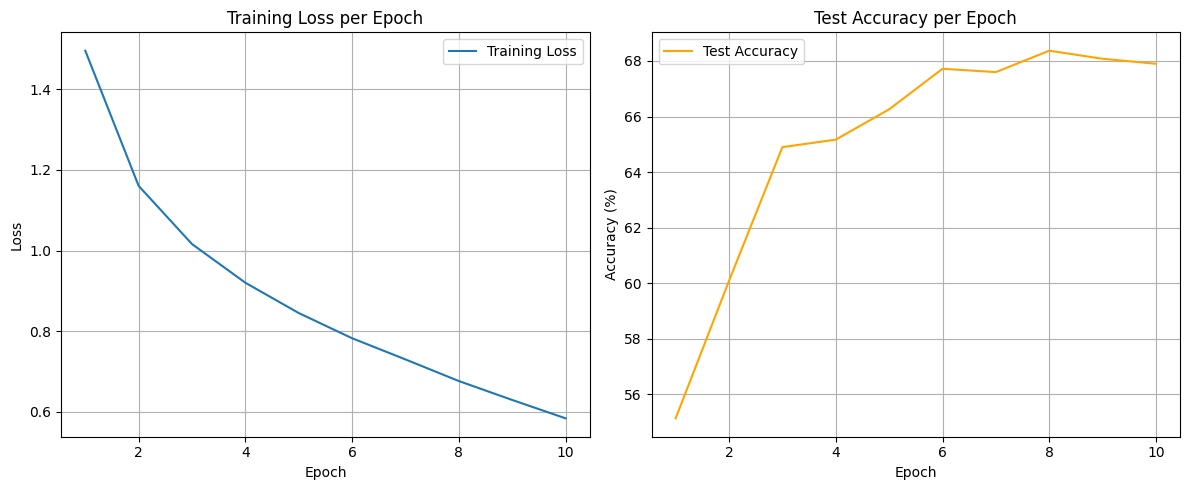

In [17]:
#────────────────────────────────────────
# [5] 모델 학습
#────────────────────────────────────────
import matplotlib.pyplot as plt

# 학습 데이터 저장용 리스트
train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    running_loss = 0.0

    index = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"[{index}/{len(train_loader)}], Loss: {loss.item():.4f}", end='\r')
        index += 1

    # Testing
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 결과 저장
    train_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(train_loss)
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}: Loss={train_loss:.3f}, Accuracy={accuracy:.1f}%')

print(f'\n최종 정확도: {accuracy:.1f}%')

# 차트 그리기
plt.figure(figsize=(12, 5))

# 훈련 손실 차트
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

# 테스트 정확도 차트
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()